In [1]:
import random
import numpy as np
import math
import pylab
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
from ipywidgets import interact, interactive, fixed, interact_manual
sns.set()

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


In [3]:
class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, simultaneous_update = True):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf  
        self.truth_seeking = truth_seeking
        self.simultaneous_update = simultaneous_update
    
    def update(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:
            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1 - self.truth_seeking) * np.average(confidants_opinions)
                
    def update_asynch(self):
        '''update asynchronously: agents update in different order'''
        if self.conf == 0: 
            confidants_opinions = [self.opinion]
        else:
            confidants_opinions = [a.opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.opinion - a.opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1 - self.truth_seeking)* np.average(confidants_opinions)
    
    def step(self):
        
        if self.simultaneous_update: 
            self.update()
        else:
            self.update_asynch()
        
class DeliberationModel(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, simultaneous_update=True):
        
        self.num_experts = num_experts        
        self.schedule = RandomActivation(self)
        self.truth = truth
        self.conf = conf
        self.running = True
        # Initialize the experts
        agent_id = 0
        for i in range(num_experts): 
            init_opinion = random.random() # initial opinion is a random number between 0 and 1
            e = Expert(i, self, init_opinion, conf, truth_seeking, simultaneous_update = simultaneous_update)
            self.schedule.add(e)
              
    def num_groups(self): 
        '''a group is defined to be a collection of agents whose opinion differs '''
        groups = list()

        opinions = [e.opinion for e in self.schedule.agents]
        for o in opinions: 
            
            for g in groups:
                if math.fabs(max(g + [o]) - min(g + [o])) < self.conf:
                    g.append(o)
                    break
            else:
                groups.append([o])     
        return len(groups)
        
    def step(self):
        self.schedule.step()

In [4]:
num_agents = 50
conf = 0.1  
truth_seeking = 0.05
truth = 0.7
num_trials = 20

m_simult = DeliberationModel(num_agents, truth, conf, truth_seeking)
m_async = DeliberationModel(num_agents, truth, conf, truth_seeking, simultaneous_update = False)

expert_opinions = {e.unique_id:[e.opinion] for e in m_simult.schedule.agents }
expert_opinions_async = {e.unique_id:[e.opinion] for e in m_async.schedule.agents }

for num_trials in range(num_trials): 
    m_simult.step()
    for e in m_simult.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)
    
    m_async.step()
    for e in m_async.schedule.agents: 
        expert_opinions_async[e.unique_id].append(e.opinion)
        


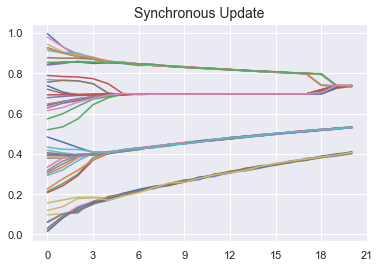

In [5]:
df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m_simult.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title("Synchronous Update", fontsize=14)
plt.show();


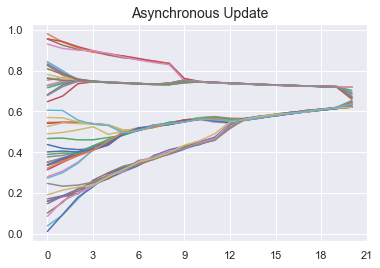

In [6]:
df = pd.DataFrame(expert_opinions_async)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for e in m_async.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title("Asynchronous Update", fontsize=14)
plt.show();

In [7]:
num_agents = 50
confs = [0.01, 0.05, 0.075, 0.1, 0.2]
truth_seeking = 0.0
truth = 0.5
num_rounds = 20
num_experiments = 1000

avg_num_groups = { conf: 0 for conf in confs }
for conf in confs: 
    
    num_groups = list()
    for e in range(num_experiments):
        m = DeliberationModel(num_agents, truth, conf, truth_seeking)
        for nr in range(num_rounds): 
            m.step()
        num_groups.append(m.num_groups())
    avg_num_groups[conf] = np.average(num_groups)

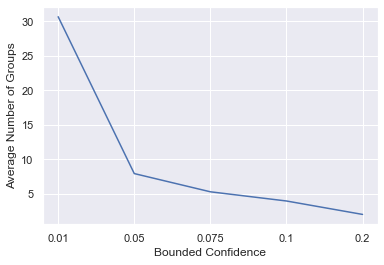

In [8]:
plt.plot([str(c) for c in confs], [avg_num_groups[conf] for conf in confs])
plt.xlabel("Bounded Confidence")
plt.ylabel("Average Number of Groups")
plt.show();

In [9]:
class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf  
        self.truth_seeking = truth_seeking
        self.noise = noise
    
    def update(self):
        
        self.old_opinion = self.opinion
        confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                              if math.fabs(self.old_opinion - a.old_opinion) < self.conf]
        
        self.opinion = np.average(confidants_opinions)
    
    def update_with_truth_seeking(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)

    def update_with_noisy_truth_seeking(self):
        
        noise = np.random.uniform(-self.noise,self.noise,1)[0]
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * (self.model.truth + noise) + (1-self.truth_seeking)*np.average(confidants_opinions)
    
    def step(self):
        
        if self.truth_seeking is not None: 
            if self.noise >  0:
                self.update_with_noisy_truth_seeking()
            else: 
                self.update_with_truth_seeking()
        else: 
            self.update()

class DeliberationModel(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, noise = 0):
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.noise = noise
        
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            
            init_opinion = random.random()
            e = Expert(i, self, init_opinion, conf, truth_seeking, noise = self.noise)
            self.schedule.add(e)
        
    def step(self):
        self.schedule.step()

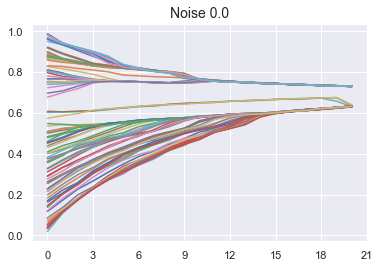

In [10]:
num_agents = 100
conf = 0.05
truth_seeking = 0.1
truth = 0.7
noise = 0.0
num_trials = 20

m = DeliberationModel(num_agents, truth, conf, truth_seeking, noise = noise)

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for num_trials in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title(f"Noise {noise}", fontsize=14)
plt.show();


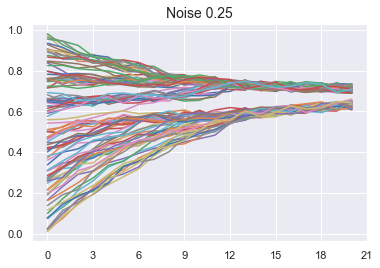

In [11]:
num_agents = 100
conf = 0.05
truth_seeking = 0.1
truth = 0.7
noise = 0.25
num_trials = 20

m = DeliberationModel(num_agents, truth, conf, truth_seeking, noise = noise)

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for num_trials in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title(f"Noise {noise}", fontsize=14)
plt.show();


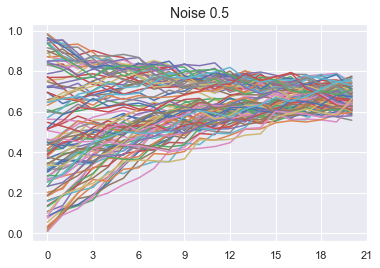

In [12]:
num_agents = 100
conf = 0.05
truth_seeking = 0.1
truth = 0.7
noise = 0.5
num_trials = 20

m = DeliberationModel(num_agents, truth, conf, truth_seeking, noise = noise)

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for num_trials in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title(f"Noise {noise}", fontsize=14)
plt.show();
